**Objective : Classify SMS text messages as 'Spam' or 'Ham' using Natural Languange Processing techniques**

In [0]:
import pandas as pd
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

from matplotlib import pyplot
import numpy as np
%matplotlib inline

In [7]:
# Store stopwords in stopwords variable
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
# We will use PorterStemmer in this project
ps = nltk.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load the SMS SPAM Collection dataset
data = pd.read_csv('/content/SMSSpamCollection.tsv', sep='\t', header=None)
data.columns = ['label', 'body_text']
data.head()

,label,body_text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [0]:
def count_punct(text):
  """
  This function returns the count of the number of punctuations in the input text message
  """
  count = sum([1 for char in text if char in string.punctuation])
  return round(count/(len(text) - text.count(" ")), 3)*100

In [0]:
# Feature engineering :
  # body_len - Number of characters in the text
  # punct% - Percentage of punctuations in the text
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

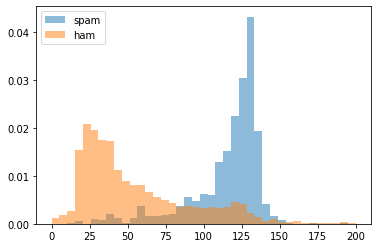

In [11]:
# Plot histogram to visualize the number of characters in the text - Spam vs Ham
# Clearly we can see that the number of characters in a Spam text is greater than Ham
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5, label='spam', density=True)
pyplot.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5, label='ham', density=True)
pyplot.legend(loc='upper left')
pyplot.show()

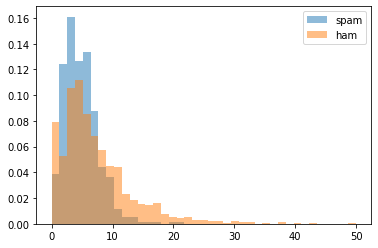

In [12]:
# Plot histogram to visualize the percentage of punctuations in the text - Spam vs Ham
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']=='spam']['punct%'], bins, alpha=0.5, density=True, label='spam')
pyplot.hist(data[data['label']=='ham']['punct%'], bins, alpha=0.5, density=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

In [0]:
def clean_text(text):
    """
    This function returns cleaned text - Remove punctuation, tokenize, stemming, remove stopwords
    """
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [0]:
# Split the dataset into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

In [15]:
# We will use TfidfVectorizer for vectorizing body_text column in our dataset
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

# Concat the transformed tfidf_train/tfidf_test with it's corresponding body_len and punct%
X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,7138,7139,7140,7141,7142,7143,7144,7145,7146,7147,7148,7149,7150,7151,7152,7153,7154,7155,7156,7157,7158,7159,7160,7161,7162,7163,7164,7165,7166,7167,7168,7169,7170,7171,7172,7173,7174,7175,7176,7177
0,141,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,135,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39,5.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,61,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [17]:
# RandomForestClassifier model
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 8.415 / Predict time: 0.165 ---- Precision: 0.984 / Recall: 0.847 / Accuracy: 0.978


In [18]:
# GradientBoostingClassifier model
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 153.228 / Predict time: 0.082 ---- Precision: 0.903 / Recall: 0.867 / Accuracy: 0.969


**Comparing RandomForestClassifier with  GradientBoostingClassifier we find that:**


*   RandomForestClassifier's training/fit time is <<<(less than) GradientBoostingClassifier
*     RandomForestClassifier's Predict time is >>>(greater than) GradientBoostingClassifier
*   RandomForestClassifier's Precision is >>>(greater than) GradientBoostingClassifier
*  RandomForestClassifier's recall is <<<(less than) GradientBoostingClassifier
*  Accuracy for RandomForestClassifier and GradientBoostingClassifier are almost same*


  